# Charts

## Imports

In [283]:
import matplotlib.pyplot as plt
import csv
import ast
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support, fbeta_score
import os
from util import Util
import configparser
import datetime
import numpy as np
import networkx as nx
import osmnx as ox
import pandas as pd 
import matplotlib.patches as mpatches

from evaluation import EvalUtil
from util import HighwayExtractor


## Variables and Constants

### Constants

In [181]:
# list of all available methods
method_names = ['sp', 'fp', 'minrtc', 'minturn',
                'vp-all', 'vp-lopt', 'vp-skyline', 'vp-div-10', 'vp-div-30', 'vp-div-70',
                'pen-all', 'pen-lopt', 'pen-skyline', 'pen-div-10', 'pen-div-30', 'pen-div-70',
                'batch-15-all', 'batch-15-lopt', 'batch-15-skyline', 'batch-15-div-10', 'batch-15-div-30', 'batch-15-div-70',
                'batch-30-all', 'batch-30-lopt', 'batch-30-skyline', 'batch-30-div-10', 'batch-30-div-30', 'batch-30-div-70',
                'batch-60-all', 'batch-60-lopt', 'batch-60-skyline', 'batch-60-div-10', 'batch-60-div-30', 'batch-60-div-70',
               ]

methodColors = {
    'sp': '#ff7f00',
    'fp': '#e31a1c',
    'minrtc': '#1f78b4',
    'minturn': '#33a02c',
    
    'vp-all': '#473681',
    'vp-lopt': '#a479be',
    'vp-skyline': '#ffc7ff',
    'vp-div-10': '#00a6f9',
    'vp-div-30': '#00cbff',
    'vp-div-70': '#00eeff',
    
    'pen-all':'#007b7e',
    'pen-lopt': '#31b5b8',
    'pen-skyline': '#58f2f6',
    'pen-div-10': '#7bad3d',
    'pen-div-30': '#bab10e',
    'pen-div-70': '#ffaa00',
    
    'batch-15-all': '#700000',
    'batch-30-all': '#be0000',
    'batch-60-all': '#ffc5a1',
    
    'batch-30-lopt': '#e28800',
    'batch-30-skyline': '#FF7777',
    'batch-30-div-10': '#f59c28',
    'batch-30-div-30': '#ccd00d',
    'batch-30-div-70': '#6bff66',
}
methodLabels = {
    'sp': 'Shortest',
    'fp': 'Fastest',
    'minrtc': 'Min-HP',
    'minturn': 'Min-Turns',
    
    'vp-all': 'SvPE',
    'vp-lopt': 'SvPE-LOpt',
    'vp-skyline': 'SvPE-Sky',
    'vp-div-10': 'SvDiv10',
    'vp-div-30': 'SvDiv30',
    'vp-div-70': 'SvDiv70',
    
    'pen-all': 'PenPE',
    'pen-lopt': 'PenPE-LOpt',
    'pen-skyline': 'PenPE-Sky',
    'pen-div-10': 'PenDiv10',
    'pen-div-30': 'PenDiv30',
    'pen-div-70': 'PenDiv70',
    
    'batch-15-all': 'GrPE-15',
    'batch-30-all': 'GrPE-30',
    'batch-60-all': 'GrPE-60',
    
    'batch-30-lopt': 'GrPE-30-Lopt',
    'batch-30-skyline': 'GrPE-30=Sky',
    'batch-30-div-10': 'Batch30Div10',
    'batch-30-div-30': 'Batch30Div30',
    'batch-30-div-70': 'Batch30DivPorto, Portugal70',
}

# directory for figures
output_path = 'datasets/porto/resources/figures'

# ground truth: map matched paths. different sizes: train.csv=all 
# ground_truth_file = 'datasets/porto/resources/fmm/train.csv'
ground_truth_file = 'datasets/porto/resources/fmm/trajectories_2013-07.csv'
# ground_truth_file = 'datasets/porto/resources/fmm/trajectories_2013-07-01.csv'

# stored graph 
graphml_file_path = 'datasets/porto/resources/osm/graph.graphml'


### Variables

In [127]:
# graph
G_multi_graph = None
G = None
G_nodes = []

# all trip ids1374772366620000260
tripIds = []

# ground truht variables
gt_path_vectors = {}
gt_path_edges = {}
gt_path_lengths = {}
tripsTimestamps = {}

# statistics dicts
precisions = {}
recalls = {}
recallsATn = {}
accuracies = {}
f1s = {}

## Helper Methods

In [128]:
# def get_path_vector_from_nodes(G_nodes,path_nodes):
#     pv = []
#     nodeSet = set(path_nodes)
#     for node in G_nodes:
#         if node in nodeSet:
#             pv.append(1) 
#         else:
#             pv.append(0)
#     return pv

def get_path_vector_from_edges(G_nodes,path_edges):
    pv = []
    nodeSet = set()
    
    for (a,b) in path_edges:
        nodeSet.add(a)
        nodeSet.add(b)
        
    for node in G_nodes:
        if node in nodeSet:
            pv.append(1) 
        else:
            pv.append(0)
    return pv

# def get_path_edges(G_nodes,path_nodes):
#     pe = []

#     for i in range(0,len(path_nodes)-1):
#         pe.append((path_nodes[i],path_nodes[i+1]))
    
#     return pe

def get_path_length(G,path_edges):
    length = 0
    for (a,b) in path_edges:
        length += G.edges[a,b]['length']
    return length

## Load Data

### Load Graph

In [129]:
G_multi_graph = ox.load_graphml(graphml_file_path)
G = ox.get_digraph(G_multi_graph, weight='length')

print('G nodes', len(G.nodes()))
print('G edges', len(G.edges()))

G_nodes = list(G.nodes)

G nodes 78080
G edges 183404


### Load statistics

In [321]:
for method_name in method_names:
    
    if method_name in ['sp', 'fp', 'minrtc', 'minturn']:
        dir_path = os.path.join('datasets/porto/resources/', 'eval-' + method_name)
    else:
        dir_path = os.path.join('datasets/porto/resources/', method_name)
    print('loading stats for ' + method_name + ' from directory: ' + dir_path)
    (p, r, rn, a) = EvalUtil.load_precisions(dir_path)

    precisions[method_name] = p
    recalls[method_name] = r
    recallsATn[method_name] = rn
    accuracies[method_name] = a



loading stats for sp from directory: datasets/porto/resources/eval-sp
loading stats for fp from directory: datasets/porto/resources/eval-fp
loading stats for minrtc from directory: datasets/porto/resources/eval-minrtc
loading stats for minturn from directory: datasets/porto/resources/eval-minturn
loading stats for vp-all from directory: datasets/porto/resources/vp-all
loading stats for vp-lopt from directory: datasets/porto/resources/vp-lopt
1374658028620000037 skipping, empty node set!
loading stats for vp-skyline from directory: datasets/porto/resources/vp-skyline
loading stats for vp-div-10 from directory: datasets/porto/resources/vp-div-10
1372672328620000261 skipping, empty node set!
1372699661620000235 skipping, empty node set!
loading stats for vp-div-30 from directory: datasets/porto/resources/vp-div-30
1372672328620000261 skipping, empty node set!
1372699661620000235 skipping, empty node set!
loading stats for vp-div-70 from directory: datasets/porto/resources/vp-div-70
137267

1373761535620000406 skipping, empty node set!
1373782682620000517 skipping, empty node set!
1373783233620000233 skipping, empty node set!
1373801612620000499 skipping, empty node set!
1373809626620000617 skipping, empty node set!
1373812869620000570 skipping, empty node set!
1373821441620000514 skipping, empty node set!
1373823520620000473 skipping, empty node set!
1373823977620000658 skipping, empty node set!
1373834238620000570 skipping, empty node set!
1373836595620000617 skipping, empty node set!
1373866931620000351 skipping, empty node set!
1373879015620000067 skipping, empty node set!
1373879422620000195 skipping, empty node set!
1373881130620000435 skipping, empty node set!
1373884199620000662 skipping, empty node set!
1373888816620000314 skipping, empty node set!
1373890041620000324 skipping, empty node set!
1373898925620000594 skipping, empty node set!
1373903491620000507 skipping, empty node set!
1373904185620000353 skipping, empty node set!
1373905033620000632 skipping, empt

1374887543620000651 skipping, empty node set!
1374903450620000308 skipping, empty node set!
1374919313620000446 skipping, empty node set!
1374919716620000347 skipping, empty node set!
1374919961620000523 skipping, empty node set!
1374923504620000453 skipping, empty node set!
1374937526620000619 skipping, empty node set!
1374949462620000083 skipping, empty node set!
1374953773620000089 skipping, empty node set!
1374957288620000178 skipping, empty node set!
1374958777620000384 skipping, empty node set!
1374960354620000269 skipping, empty node set!
1374960924620000279 skipping, empty node set!
1374961318620000653 skipping, empty node set!
1374961954620000467 skipping, empty node set!
1374979568620000616 skipping, empty node set!
1374982229620000367 skipping, empty node set!
1374987218620000089 skipping, empty node set!
1375008543620000515 skipping, empty node set!
1375015931620000333 skipping, empty node set!
1375052203620000160 skipping, empty node set!
1375055207620000003 skipping, empt

loading stats for batch-30-div-70 from directory: datasets/porto/resources/batch-30-div-70
1372672328620000261 skipping, empty node set!
1372699661620000235 skipping, empty node set!
loading stats for batch-60-all from directory: datasets/porto/resources/batch-60-all
loading stats for batch-60-lopt from directory: datasets/porto/resources/batch-60-lopt
1372664679620000186 skipping, empty node set!
1372664787620000397 skipping, empty node set!
1372667871620000152 skipping, empty node set!
1372667893620000116 skipping, empty node set!
1372670071620000395 skipping, empty node set!
1372672328620000261 skipping, empty node set!
1372673370620000324 skipping, empty node set!
1372674619620000304 skipping, empty node set!
1372675613620000055 skipping, empty node set!
1372676476620000189 skipping, empty node set!
1372681212620000684 skipping, empty node set!
1372686607620000502 skipping, empty node set!
1372689662620000120 skipping, empty node set!
1372689862620000048 skipping, empty node set!
1

In [323]:
def fbeta_score(beta, p, r):
    return (1 + beta * beta) * ((p * r) / ((beta * beta * p) + r))

for method_name in method_names:
    print(method_name)
    print("-------------")
    precision = (sum(precisions[method_name].values())/len(precisions[method_name]))
    print("precision = ", "{:.3f}".format(precision))
    recall = (sum(recalls[method_name].values())/len(recalls[method_name]))
    print("recall = ", "{:.3f}".format(recall))
#     print("f0.25 = ","{:.3f}".format(fbeta_score(0.25, precision, recall)))
    print("f0.5 = ","{:.3f}".format(fbeta_score(0.5, precision, recall)))
    print("f1 = ","{:.3f}".format(fbeta_score(1, precision, recall)))
    print("f2 = ","{:.3f}".format(fbeta_score(2, precision, recall)))
#     print("f4 = ","{:.3f}".format(fbeta_score(4, precision, recall)))
    print("recall@n = ","{:.3f}".format((sum(recallsATn[method_name].values())/len(recallsATn[method_name]))))
    print("accuracy = ","{:.3f}".format((sum(accuracies[method_name].values())/len(accuracies[method_name]))))
    print("-------------")
    print()


sp
-------------
precision =  0.560
recall =  0.486
f0.5 =  0.543
f1 =  0.520
f2 =  0.499
recall@n =  0.430
accuracy =  0.430
-------------

fp
-------------
precision =  0.613
recall =  0.525
f0.5 =  0.593
f1 =  0.566
f2 =  0.541
recall@n =  0.483
accuracy =  0.482
-------------

minrtc
-------------
precision =  0.611
recall =  0.531
f0.5 =  0.593
f1 =  0.568
f2 =  0.545
recall@n =  0.490
accuracy =  0.488
-------------

minturn
-------------
precision =  0.575
recall =  0.469
f0.5 =  0.550
f1 =  0.517
f2 =  0.487
recall@n =  0.444
accuracy =  0.439
-------------

vp-all
-------------
precision =  0.015
recall =  1.000
f0.5 =  0.018
f1 =  0.029
f2 =  0.069
recall@n =  0.957
accuracy =  0.012
-------------

vp-lopt
-------------
precision =  0.053
recall =  0.953
f0.5 =  0.065
f1 =  0.100
f2 =  0.215
recall@n =  0.908
accuracy =  0.041
-------------

vp-skyline
-------------
precision =  0.553
recall =  0.606
f0.5 =  0.563
f1 =  0.579
f2 =  0.595
recall@n =  0.565
accuracy =  0.466
--

### Load Ground Truth

In [132]:
tripsTimestamps = {}
tripsErrors = {}
errorList = []

total_rows = sum(1 for _ in open(ground_truth_file)) - 1

with open(ground_truth_file, newline='') as csvfile:
    spamreader = csv.DictReader(csvfile, delimiter=',', quotechar='"')
    i = 0
    for row in spamreader:
        lst = ast.literal_eval(row['CPATH'])
        tripId = int(row['TRIP_ID'])
        
        if i % 500 == 0:
            print(i / total_rows * 100, '%; trip_id: ', tripId)
        i += 1
        
        gt_path_edges[tripId] = lst
        tripsTimestamps[int(row['TRIP_ID'])] = datetime.datetime.strptime(row['TIMESTAMP'], '%Y-%m-%d %H:%M:%S')
        #print(tripId)
        #for (a,b) in lst:
        #    print("----- ",a,b)
        #    print("----- l#### Varying error to fastest pathength = ",G.edges[a,b]['length'])
        gt_path_lengths[tripId] = get_path_length(G,lst)
        gt_path_vectors[tripId] = get_path_vector_from_edges(G_nodes,lst)
        tripIds.append(tripId)
        tripsTimestamps[tripId] = datetime.datetime.strptime(row['TIMESTAMP'], '%Y-%m-%d %H:%M:%S')
        dist = nx.dijkstra_path_length(G, int(row['START_NODE']), int(row['END_NODE']), weight='weight_duration')
        tripsErrors[tripId] = float(row['REAL_DURATION'])-dist
        errorList.append(abs(float(row['REAL_DURATION'])-dist))
        

0.0 %; trip_id:  1372636853620000380
0.4905760343795685 %; trip_id:  1372664868620000074
0.981152068759137 %; trip_id:  1372671559620000372
1.4717281031387055 %; trip_id:  1372679581620000682
1.962304137518274 %; trip_id:  1372688307620000554
2.4528801718978426 %; trip_id:  1372698216620000076
2.943456206277411 %; trip_id:  1372712434620000031
3.434032240656979 %; trip_id:  1372741046620000463
3.924608275036548 %; trip_id:  1372754793620000480
4.415184309416116 %; trip_id:  1372763449620000006
4.905760343795685 %; trip_id:  1372772720620000611
5.396336378175253 %; trip_id:  1372781606620000261
5.886912412554822 %; trip_id:  1372791793620000171
6.37748844693439 %; trip_id:  1372817617620000446
6.868064481313958 %; trip_id:  1372839583620000395
7.358640515693528 %; trip_id:  1372847273620000464
7.849216550073096 %; trip_id:  1372857871620000554
8.339792584452663 %; trip_id:  1372867588620000114
8.830368618832232 %; trip_id:  1372877439620000188
9.320944653211802 %; trip_id:  137289273962

78.98274153511052 %; trip_id:  1374743905620000518
79.47331756949009 %; trip_id:  1374752982620000215
79.96389360386966 %; trip_id:  1374762031620000233
80.45446963824924 %; trip_id:  1374770260620000562
80.94504567262881 %; trip_id:  1374780602620000600
81.43562170700837 %; trip_id:  1374796901620000450
81.92619774138794 %; trip_id:  1374824357620000152
82.41677377576751 %; trip_id:  1374832654620000049
82.90734981014708 %; trip_id:  1374840847620000252
83.39792584452664 %; trip_id:  1374849753620000421
83.88850187890621 %; trip_id:  1374857704620000153
84.37907791328578 %; trip_id:  1374868068620000333
84.86965394766534 %; trip_id:  1374878277620000171
85.36022998204493 %; trip_id:  1374891011620000101
85.85080601642449 %; trip_id:  1374900711620000054
86.34138205080404 %; trip_id:  1374916143620000276
86.83195808518363 %; trip_id:  1374928634620000042
87.32253411956319 %; trip_id:  1374944127620000452
87.81311015394276 %; trip_id:  1374957118620000610
88.30368618832233 %; trip_id:  

### Calculate number of paths

In [197]:

def get_path_count(base_dir):
    path_count = {}
    
    num_directories = len(os.listdir(base_dir))
    i = 0
    for subdir_name in os.listdir(base_dir):
        i += 1
        print(base_dir, 'counting paths in directory', i, 'of', num_directories)
        subdir_path = os.path.join(base_dir, subdir_name)
        for filename in os.listdir(subdir_path):
            file_path = os.path.join(subdir_path, filename)
            line_count = sum(1 for _ in open(file_path)) - 1
            trip_id = int(filename[:filename.index('.')])
            path_count[trip_id] = line_count
#         break #TODO: remove this for full results!
    return path_count
            

path_counts = {}
path_counts['vp-all'] = get_path_count('datasets/porto/resources/vp')
path_counts['pen-all'] = get_path_count('datasets/porto/resources/pen')



datasets/porto/resources/vp counting paths in directory 1 of 31
datasets/porto/resources/vp counting paths in directory 2 of 31
datasets/porto/resources/vp counting paths in directory 3 of 31
datasets/porto/resources/vp counting paths in directory 4 of 31
datasets/porto/resources/vp counting paths in directory 5 of 31
datasets/porto/resources/vp counting paths in directory 6 of 31
datasets/porto/resources/vp counting paths in directory 7 of 31
datasets/porto/resources/vp counting paths in directory 8 of 31
datasets/porto/resources/vp counting paths in directory 9 of 31
datasets/porto/resources/vp counting paths in directory 10 of 31
datasets/porto/resources/vp counting paths in directory 11 of 31
datasets/porto/resources/vp counting paths in directory 12 of 31
datasets/porto/resources/vp counting paths in directory 13 of 31
datasets/porto/resources/vp counting paths in directory 14 of 31
datasets/porto/resources/vp counting paths in directory 15 of 31
datasets/porto/resources/vp counti

In [246]:
# path_counts['vp-all']
# path_counts['pen-all']
from statistics import mean
print('pen-all avg:', mean(path_counts['pen-all'].values()))
print('vp-all avg:', mean(path_counts['vp-all'].values()))


pen-all avg: 14.350232042464262
vp-all avg: 4733.806987765034


### Calculate error limits

In [198]:
errorList.sort()
splittedLists = np.array_split(errorList,10)
errorLimits = []
for mlist in splittedLists:
    errorLimits.append([mlist[0],mlist[-1]])
    
errorLimits[0][0] = 0.0
errorLimits[-1][1] = float('inf')

errorLimits

[[0.0, 353.0],
 [353.0, 413.0],
 [413.0, 469.0],
 [469.0, 529.0],
 [529.0, 596.0],
 [596.0, 670.0],
 [670.0, 759.0],
 [759.0, 884.0],
 [884.0, 1101.0],
 [1101.0, inf]]

### split ids by time intervall

In [199]:
tripIdsSplit = []
for i in range(0,6):
    tripIdsSplit.append(set())

for tripId in tripIds:
    tripTime = tripsTimestamps[tripId].time()
    # check if tripid is in statistics
    if tripId not in precisions['minturn']:
        continue
    if tripTime >= datetime.time.fromisoformat('00:00:00') and tripTime < datetime.time.fromisoformat('04:00:00'):
        tripIdsSplit[0].add(tripId)
    elif tripTime >= datetime.time.fromisoformat('04:00:00') and tripTime < datetime.time.fromisoformat('08:00:00'):
        tripIdsSplit[1].add(tripId)
    elif tripTime >= datetime.time.fromisoformat('08:00:00') and tripTime < datetime.time.fromisoformat('12:00:00'):
        tripIdsSplit[2].add(tripId)
    elif tripTime >= datetime.time.fromisoformat('12:00:00') and tripTime < datetime.time.fromisoformat('16:00:00'):
        tripIdsSplit[3].add(tripId)
    elif tripTime >= datetime.time.fromisoformat('16:00:00') and tripTime < datetime.time.fromisoformat('20:00:00'):
        tripIdsSplit[4].add(tripId)
    elif tripTime >= datetime.time.fromisoformat('20:00:00') and tripTime <= datetime.time.fromisoformat('23:59:59'):
        tripIdsSplit[5].add(tripId)

## Single route recovery charts

### Cummulative reverse-order histograms

saving pdf
plotting


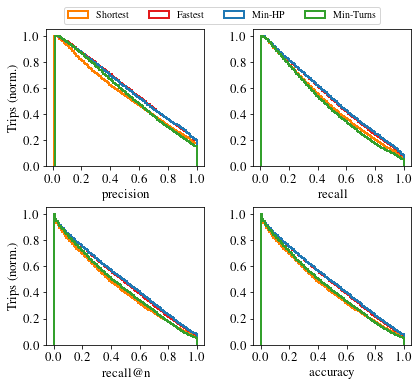

In [200]:
all_methods = ['sp','fp','minrtc','minturn']

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(5.9,5))
fig.tight_layout()

plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=13)
plt.rc('ytick', labelsize=13)
plt.rc('axes', labelsize=13)

for method in all_methods:
    ax1.hist(precisions[method].values(), histtype='step', bins=100, linewidth=2, 
             cumulative=-1, color=methodColors[method], 
             label=methodLabels[method], density=True)  # arguments are passed to np.histogram


ax1.set_ylabel('Trips (norm.)')
ax1.set_xlabel('precision')
ax1.set_ylim(0,1.05)
ax1.set_xticks([0,0.2,0.4,0.6,0.8,1.0])
ax1.set_yticks([0,0.2,0.4,0.6,0.8,1.0])
    
for method in all_methods:
    ax2.hist(recalls[method].values(), histtype='step', bins=100, linewidth=2, cumulative=-1, color=methodColors[method], label=methodLabels[method], density=True)  # arguments are passed to np.histogram

#ax2.set_ylabel('Trips (norm.)')
ax2.set_xlabel('recall')
ax2.set_ylim(0,1.05)
ax2.set_xticks([0,0.2,0.4,0.6,0.8,1.0])
ax2.set_yticks([0,0.2,0.4,0.6,0.8,1.0])

for method in all_methods:
    ax3.hist(recallsATn[method].values(), histtype='step', bins=100, linewidth=2, cumulative=-1, color=methodColors[method], label=methodLabels[method], density=True)  # arguments are passed to np.histogram

ax3.set_ylabel('Trips (norm.)')
ax3.set_xlabel('recall@n')
ax3.set_ylim(0,1.05)
ax3.set_xticks([0,0.2,0.4,0.6,0.8,1.0])
ax3.set_yticks([0,0.2,0.4,0.6,0.8,1.0])
    
for method in all_methods:
    ax4.hist(accuracies[method].values(), histtype='step', bins=100, linewidth=2, cumulative=-1, color=methodColors[method], label=methodLabels[method], density=True)  # arguments are passed to np.histogram

#ax2.set_ylabel('Trips (norm.)')
ax4.set_xlabel('accuracy')
ax4.set_ylim(0,1.05)
ax4.set_xticks([0,0.2,0.4,0.6,0.8,1.0])
ax4.set_yticks([0,0.2,0.4,0.6,0.8,1.0])

plt.subplots_adjust(hspace=0.3)
plt.legend(loc=9,bbox_to_anchor=(-0.2, 2.5),ncol=4)

print('saving pdf')
plt.savefig(os.path.join(output_path, 'singe-route-hists.pdf'), bbox_inches='tight')

print('plotting')
plt.show()

### Bar charts

#### Varying time slot

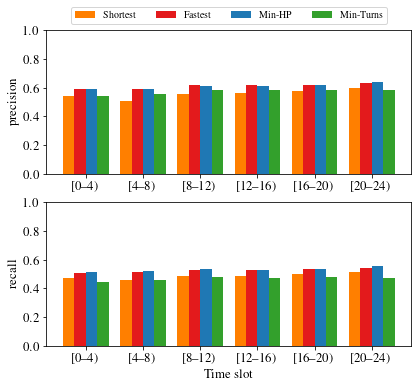

In [201]:
all_methods = ['sp','fp','minrtc','minturn']

precisionsSplitAvg = {}
recallsSplitAvg = {}

for method in all_methods:
    precisionsSplitAvg[method] = []
    recallsSplitAvg[method] = []
    for i in range(0,len(tripIdsSplit)):  
        myList = [precisions[method][t] for t in tripIdsSplit[i]]
        precisionsSplitAvg[method].append(sum(myList)/len(myList))
        
        myList = [recalls[method][t] for t in tripIdsSplit[i]]
        recallsSplitAvg[method].append(sum(myList)/len(myList))

fig, ((ax1), (ax2)) = plt.subplots(2, 1, figsize=(5.9,5))
fig.tight_layout()

plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=13)
plt.rc('ytick', labelsize=13)
plt.rc('axes', labelsize=13)

X = np.arange(6)

ax1.bar(X-0.3,precisionsSplitAvg['sp'], width = 0.2, label=methodLabels['sp'], color=methodColors['sp'])
ax1.bar(X-0.1,precisionsSplitAvg['fp'], width = 0.2, label=methodLabels['fp'], color=methodColors['fp'])
ax1.bar(X+0.1,precisionsSplitAvg['minrtc'], width = 0.2, label=methodLabels['minrtc'], color=methodColors['minrtc'])
ax1.bar(X+0.3,precisionsSplitAvg['minturn'], width = 0.2, label=methodLabels['minturn'], color=methodColors['minturn'])    
ax1.set_ylim(0,1)
ax1.set_xticks(X,['[0--4)','[4--8)','[8--12)','[12--16)','[16--20)','[20--24)'])
ax1.set_ylabel('precision')
#ax1.set_xlabel('Time slot')

ax2.bar(X-0.3,recallsSplitAvg['sp'], width = 0.2, label=methodLabels['sp'], color=methodColors['sp'])
ax2.bar(X-0.1,recallsSplitAvg['fp'], width = 0.2, label=methodLabels['fp'], color=methodColors['fp'])
ax2.bar(X+0.1,recallsSplitAvg['minrtc'], width = 0.2, label=methodLabels['minrtc'], color=methodColors['minrtc'])
ax2.bar(X+0.3,recallsSplitAvg['minturn'], width = 0.2, label=methodLabels['minturn'], color=methodColors['minturn'])
ax2.set_ylim(0,1)
ax2.set_xticks(X,['[0--4)','[4--8)','[8--12)','[12--16)','[16--20)','[20--24)'])
ax2.set_ylabel('recall')
ax2.set_xlabel('Time slot')

plt.subplots_adjust(hspace=0.2)
plt.legend(loc=9,bbox_to_anchor=(0.5, 2.4),ncol=4)

plt.savefig(os.path.join(output_path, 'singe-route-timeslots.pdf'), bbox_inches='tight')

plt.show()

#### Varying error to fastest path

[0.7358554255682541, 0.6962070844326776, 0.6458694202731405, 0.6129629723133905, 0.570698780021503, 0.5380250202861045, 0.4938562810218055, 0.4589717042504704, 0.41925886251513994, 0.42641438250012503]
[0.7543081255470131, 0.7204416586972114, 0.678719319161162, 0.6530571338984996, 0.6192897411398196, 0.5960073113199938, 0.56243750722636, 0.534395280475873, 0.5062105347860456, 0.5068710464943242]
saving pdf


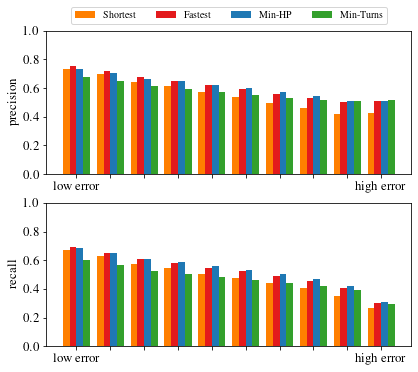

In [202]:
all_methods = ['sp','fp','minrtc','minturn']

tripIdsSplitByError = []
for i in range(0,len(errorLimits)):
    tripIdsSplitByError.append(set())

for tripId in tripIds:
    # check if tripid is in statistics
    if tripId not in precisions['minturn']:
        continue
    
    tripError = tripsErrors[tripId]
    
    for i in range(0,len(errorLimits)):
        if tripError >= errorLimits[i][0] and tripError < errorLimits[i][1]:
            tripIdsSplitByError[i].add(tripId)
            
precisionsSplitByErrorAvg = {}
recallsSplitByErrorAvg = {}

for method in all_methods:
    precisionsSplitByErrorAvg[method] = []
    recallsSplitByErrorAvg[method] = []
    for i in range(0,len(tripIdsSplitByError)):  
        myList = [precisions[method][t] for t in tripIdsSplitByError[i]]
        if len(myList) == 0:
            precisionsSplitByErrorAvg[method].append(0)
            recallsSplitByErrorAvg[method].append(0)
            continue
        precisionsSplitByErrorAvg[method].append(sum(myList)/len(myList))
        
        myList = [recalls[method][t] for t in tripIdsSplitByError[i]]
        if len(myList) == 0:
            recallsSplitByErrorAvg[method].append(0)
        recallsSplitByErrorAvg[method].append(sum(myList)/len(myList))

print(precisionsSplitByErrorAvg['sp'])
print(precisionsSplitByErrorAvg['fp'])

fig, ((ax1), (ax2)) = plt.subplots(2, 1, figsize=(5.9,5))
fig.tight_layout()

plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=13)
plt.rc('ytick', labelsize=13)
plt.rc('axes', labelsize=13)

X = np.arange(10)

ax1.bar(X-0.3,precisionsSplitByErrorAvg['sp'], width = 0.2, label=methodLabels['sp'], color=methodColors['sp'])
ax1.bar(X-0.1,precisionsSplitByErrorAvg['fp'], width = 0.2, label=methodLabels['fp'], color=methodColors['fp'])
ax1.bar(X+0.1,precisionsSplitByErrorAvg['minrtc'], width = 0.2, label=methodLabels['minrtc'], color=methodColors['minrtc'])
ax1.bar(X+0.3,precisionsSplitByErrorAvg['minturn'], width = 0.2, label=methodLabels['minturn'], color=methodColors['minturn'])    
ax1.set_ylim(0,1)
ax1.set_xticks(X,['low error','','','','','','','','','high error'])
ax1.set_ylabel('precision')
#ax1.set_xlabel('Time slot')

ax2.bar(X-0.3,recallsSplitByErrorAvg['sp'], width = 0.2, label=methodLabels['sp'], color=methodColors['sp'])
ax2.bar(X-0.1,recallsSplitByErrorAvg['fp'], width = 0.2, label=methodLabels['fp'], color=methodColors['fp'])
ax2.bar(X+0.1,recallsSplitByErrorAvg['minrtc'], width = 0.2, label=methodLabels['minrtc'], color=methodColors['minrtc'])
ax2.bar(X+0.3,recallsSplitByErrorAvg['minturn'], width = 0.2, label=methodLabels['minturn'], color=methodColors['minturn'])
ax2.set_ylim(0,1)
ax2.set_xticks(X,['low error','','','','','','','','','high error'])
ax2.set_ylabel('recall')
#ax2.set_xlabel('Time slot')

plt.subplots_adjust(hspace=0.2)
plt.legend(loc=9,bbox_to_anchor=(0.5, 2.4),ncol=4)

print('saving pdf')
plt.savefig(os.path.join(output_path, 'singe-route-errors.pdf'), bbox_inches='tight')

plt.show()

## Subnetwork revovery charts

### Path Enumeration

#### All results

saving pdf
plotting


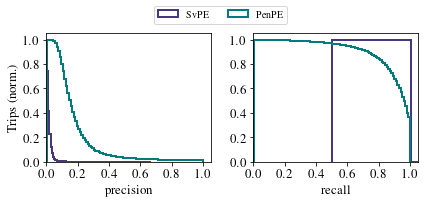

In [203]:
all_methods = ['vp-all', 'pen-all']

fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(5.9,2.4))
# recall, precision, f1

fig.tight_layout()

plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=13)
plt.rc('ytick', labelsize=13)
plt.rc('axes', labelsize=13)

for method in all_methods:
    ax1.hist(precisions[method].values(), histtype='step', bins=100, linewidth=2, 
             cumulative=-1, color=methodColors[method], 
             label=methodLabels[method], density=True)  # arguments are passed to np.histogram

ax1.set_ylabel('Trips (norm.)')
ax1.set_xlabel('precision')
ax1.set_ylim(0,1.05)
ax1.set_xlim(0,1.05)
ax1.set_xticks([0,0.2,0.4,0.6,0.8,1.0])
ax1.set_yticks([0,0.2,0.4,0.6,0.8,1.0])
    
for method in all_methods:
    ax2.hist(recalls[method].values(), histtype='step', bins=100, linewidth=2,
             cumulative=-1, color=methodColors[method], label=methodLabels[method],
             density=True)  # arguments are passed to np.histogram

#ax2.set_ylabel('Trips (norm.)')
ax2.set_xlabel('recall')
ax2.set_ylim(0,1.05)
ax2.set_xlim(0,1.05)
ax2.set_xticks([0,0.2,0.4,0.6,0.8,1.0])
ax2.set_yticks([0,0.2,0.4,0.6,0.8,1.0])

# for method in all_methods:
#     ax3.hist(recallsATn[method].values(), histtype='step', bins=100, linewidth=2, cumulative=-1, color=methodColors[method], label=methodLabels[method], density=True)  # arguments are passed to np.histogram

# ax3.set_ylabel('Trips (norm.)')
# ax3.set_xlabel('recall@n')
# ax3.set_ylim(0,1.05)
# ax3.set_xlim(0,1.05)
# ax3.set_xticks([0,0.2,0.4,0.6,0.8,1.0])
# ax3.set_yticks([0,0.2,0.4,0.6,0.8,1.0])
    
# for method in all_methods:
#     ax4.hist(accuracies[method].values(), histtype='step', bins=100, linewidth=2, cumulative=-1, color=methodColors[method], label=methodLabels[method], density=True)  # arguments are passed to np.histogram

# #ax2.set_ylabel('Trips (norm.)')
# ax4.set_xlabel('accuracy')
# ax4.set_ylim(0,1.05)
# ax4.set_xlim(0,1.05)
# ax4.set_xticks([0,0.2,0.4,0.6,0.8,1.0])
# ax4.set_yticks([0,0.2,0.4,0.6,0.8,1.0])

#for method in all_methods:
#    f1s={}
#    for trip_id, recall, precision in zip(recalls[method], recalls[method].values(), precisions[method].values()):
#        f1s[trip_id] = 2 *((precision * recall)/(precision + recall))
#    ax5.hist(f1s.values(), histtype='step', bins=100, linewidth=2,
#             cumulative=-1, color=methodColors[method], label=methodLabels[method],
#             density=True)  # arguments are passed to np.histogram
#
##ax5.set_ylabel('Trips (norm.)')
#ax5.set_xlabel('f1')
#ax5.set_ylim(0,1.05)
#ax5.set_xlim(0,1.05)
#ax5.set_xticks([0,0.2,0.4,0.6,0.8,1.0])
#ax5.set_yticks([0,0.2,0.4,0.6,0.8,1.0])


plt.subplots_adjust(hspace=0.3)
# plt.legend(loc=9,bbox_to_anchor=(-0.2, 2.5),ncol=4)
plt.legend(loc=9,bbox_to_anchor=(-0.2, 1.25),ncol=2)

print('saving pdf')
plt.savefig(os.path.join(output_path, 'PE-route-hists.pdf'), bbox_inches='tight')

print('plotting')
plt.show()

saving pdf
plotting


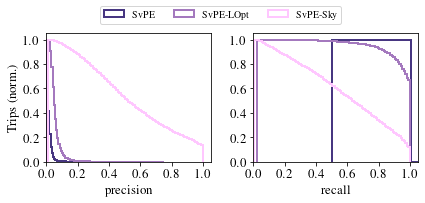

In [204]:
#vp_methods = ['vp-all', 'vp-lopt', 'vp-skyline', 'vp-div-10', 'vp-div-30', 'vp-div-70']
#pen_methods = ['pen-all', 'pen-lopt', 'pen-skyline', 'pen-div-10', 'pen-div-30', 'pen-div-70']
vp_methods = ['vp-all', 'vp-lopt', 'vp-skyline']
#pen_methods = ['pen-all', 'pen-lopt', 'pen-skyline']

fig, ((vp1, vp2)) = plt.subplots(1, 2, figsize=(5.9,2.4))

fig.tight_layout()

plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=13)
plt.rc('ytick', labelsize=13)
plt.rc('axes', labelsize=13)

for method in vp_methods:
    vp1.hist(precisions[method].values(), histtype='step', bins=100, linewidth=2, 
             cumulative=-1, color=methodColors[method], 
             label=methodLabels[method], density=True)  # arguments are passed to np.histogram

vp1.set_ylabel('Trips (norm.)')
vp1.set_xlabel('precision')
vp1.set_ylim(0,1.05)
vp1.set_xlim(0,1.05)
vp1.set_xticks([0,0.2,0.4,0.6,0.8,1.0])
vp1.set_yticks([0,0.2,0.4,0.6,0.8,1.0])
    
for method in vp_methods:
    vp2.hist(recalls[method].values(), histtype='step', bins=100, linewidth=2,
             cumulative=-1, color=methodColors[method], label=methodLabels[method],
             density=True)  # arguments are passed to np.histogram

#vp2.set_ylabel('Trips (norm.)')
vp2.set_xlabel('recall')
vp2.set_ylim(0,1.05)
vp2.set_xlim(0,1.05)
vp2.set_xticks([0,0.2,0.4,0.6,0.8,1.0])
vp2.set_yticks([0,0.2,0.4,0.6,0.8,1.0])

for method in vp_methods:
    f1s={}
    for trip_id, recall, precision in zip(recalls[method], recalls[method].values(), precisions[method].values()):
        f1s[trip_id] = 2 *((precision * recall)/(precision + recall))
    vp3.hist(f1s.values(), histtype='step', bins=100, linewidth=2,
             cumulative=-1, color=methodColors[method], label=methodLabels[method],
             density=True)  # arguments are passed to np.histogram

#vp3.set_ylabel('Trips (norm.)')
#vp3.set_xlabel('f1')
#vp3.set_ylim(0,1.05)
#vp3.set_xlim(0,1.05)
#vp3.set_xticks([0,0.2,0.4,0.6,0.8,1.0])
#vp3.set_yticks([0,0.2,0.4,0.6,0.8,1.0])

# handles1, _ = vp1.get_legend_handles_labels()
# handles2, _ = pen1.get_legend_handles_labels()
# handles = handles1 + handles2
# plt.legend(handles=handles, loc=9,bbox_to_anchor=(-0.75, 2.6),ncol=6)
vp2.legend(loc='upper center', bbox_to_anchor=(-0.2,1.25), ncol=3)
#pen2.legend(loc='lower center', bbox_to_anchor=(.5,-0.5), ncol=6)

print('saving pdf')
plt.savefig(os.path.join(output_path, 'SEL-route-hists-svpe.pdf'), bbox_inches='tight')

print('plotting')
plt.show()

saving pdf
plotting


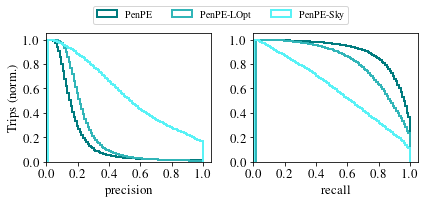

In [205]:
#vp_methods = ['vp-all', 'vp-lopt', 'vp-skyline', 'vp-div-10', 'vp-div-30', 'vp-div-70']
#pen_methods = ['pen-all', 'pen-lopt', 'pen-skyline', 'pen-div-10', 'pen-div-30', 'pen-div-70']
#vp_methods = ['vp-all', 'vp-lopt', 'vp-skyline']
pen_methods = ['pen-all', 'pen-lopt', 'pen-skyline']

#fig, ((vp1, vp2, vp3),(pen1, pen2, pen3)) = plt.subplots(2, 3, figsize=(13,4.8))
fig, ((pen1, pen2)) = plt.subplots(1, 2, figsize=(5.9,2.4))

fig.tight_layout()

plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=13)
plt.rc('ytick', labelsize=13)
plt.rc('axes', labelsize=13)

#for method in vp_methods:
#    vp1.hist(precisions[method].values(), histtype='step', bins=100, linewidth=2, 
#             cumulative=-1, color=methodColors[method], 
#             label=methodLabels[method], density=True)  # arguments are passed to np.histogram
#
#vp1.set_ylabel('Trips (norm.)')
#vp1.set_xlabel('precision')
#vp1.set_ylim(0,1.05)
#vp1.set_xlim(0,1.05)
#vp1.set_xticks([0,0.2,0.4,0.6,0.8,1.0])
#vp1.set_yticks([0,0.2,0.4,0.6,0.8,1.0])
#    
#for method in vp_methods:
#    vp2.hist(recalls[method].values(), histtype='step', bins=100, linewidth=2,
#             cumulative=-1, color=methodColors[method], label=methodLabels[method],
#             density=True)  # arguments are passed to np.histogram
#
##vp2.set_ylabel('Trips (norm.)')
#vp2.set_xlabel('recall')
#vp2.set_ylim(0,1.05)
#vp2.set_xlim(0,1.05)
#vp2.set_xticks([0,0.2,0.4,0.6,0.8,1.0])
#vp2.set_yticks([0,0.2,0.4,0.6,0.8,1.0])
#
#for method in vp_methods:
#    f1s={}
#    for trip_id, recall, precision in zip(recalls[method], recalls[method].values(), precisions[method].values()):
#        f1s[trip_id] = 2 *((precision * recall)/(precision + recall))
#    vp3.hist(f1s.values(), histtype='step', bins=100, linewidth=2,
#             cumulative=-1, color=methodColors[method], label=methodLabels[method],
#             density=True)  # arguments are passed to np.histogram
#
#vp3.set_ylabel('Trips (norm.)')
#vp3.set_xlabel('f1')
#vp3.set_ylim(0,1.05)
#vp3.set_xlim(0,1.05)
#vp3.set_xticks([0,0.2,0.4,0.6,0.8,1.0])
#vp3.set_yticks([0,0.2,0.4,0.6,0.8,1.0])
#
for method in pen_methods:
    pen1.hist(precisions[method].values(), histtype='step', bins=100, linewidth=2, 
             cumulative=-1, color=methodColors[method], 
             label=methodLabels[method], density=True)  # arguments are passed to np.histogram

pen1.set_ylabel('Trips (norm.)')
pen1.set_xlabel('precision')
pen1.set_ylim(0,1.05)
pen1.set_xlim(0,1.05)
pen1.set_xticks([0,0.2,0.4,0.6,0.8,1.0])
pen1.set_yticks([0,0.2,0.4,0.6,0.8,1.0])
    
for method in pen_methods:
    pen2.hist(recalls[method].values(), histtype='step', bins=100, linewidth=2,
              cumulative=-1, color=methodColors[method], label=methodLabels[method],
              density=True)  # arguments are passed to np.histogram

#vp2.set_ylabel('Trips (norm.)')
pen2.set_xlabel('recall')
pen2.set_ylim(0,1.05)
pen2.set_xlim(0,1.05)
pen2.set_xticks([0,0.2,0.4,0.6,0.8,1.0])
pen2.set_yticks([0,0.2,0.4,0.6,0.8,1.0])

for method in pen_methods:
    f1s={}
    for trip_id, recall, precision in zip(recalls[method], recalls[method].values(), precisions[method].values()):
        f1s[trip_id] = 2 *((precision * recall)/(precision + recall))
    pen3.hist(f1s.values(), histtype='step', bins=100, linewidth=2,
              cumulative=-1, color=methodColors[method], label=methodLabels[method],
              density=True)  # arguments are passed to np.histogram

#pen3.set_ylabel('Trips (norm.)')
#pen3.set_xlabel('f1')
#pen3.set_ylim(0,1.05)
#pen3.set_xlim(0,1.05)
#pen3.set_xticks([0,0.2,0.4,0.6,0.8,1.0])
#pen3.set_yticks([0,0.2,0.4,0.6,0.8,1.0])


plt.subplots_adjust(hspace=0.3)

# handles1, _ = vp1.get_legend_handles_labels()
# handles2, _ = pen1.get_legend_handles_labels()
# handles = handles1 + handles2
# plt.legend(handles=handles, loc=9,bbox_to_anchor=(-0.75, 2.6),ncol=6)
#vp2.legend(loc='upper center', bbox_to_anchor=(.5,1.25), ncol=6)
pen2.legend(loc='upper center', bbox_to_anchor=(-0.2,1.25), ncol=3)


print('saving pdf')
plt.savefig(os.path.join(output_path, 'SEL-route-hists-penpe.pdf'), bbox_inches='tight')

print('plotting')
plt.show()

### Number of Paths

[574.783455228306, 862.0317630961689, 1209.7506925207756, 1632.820246720188, 2200.443283873487, 2957.3258845437617, 3958.7630000982995, 5495.342465753424, 8253.191222570533, 20148.434369179493]
[9.270112670488238, 10.30258014073495, 11.305302730510487, 12.158899549637752, 13.132467786021085, 14.241595609134569, 15.312592155706282, 16.636986301369863, 18.322884012539184, 22.765709244191747]


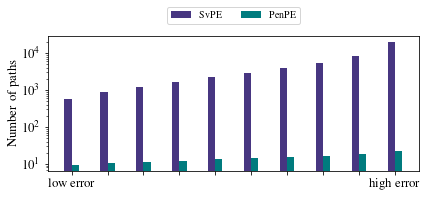

In [206]:
all_methods = ['vp-all', 'pen-all']

tripIdsSplitByError = []

for i in range(0,len(errorLimits)):
    tripIdsSplitByError.append(set())

for tripId in tripIds:
    # check if tripid is in statistics
    if tripId not in path_counts['vp-all']:
        continue
    
    tripError = tripsErrors[tripId]
    
    for i in range(0,len(errorLimits)):
        if tripError >= errorLimits[i][0] and tripError < errorLimits[i][1]:
            tripIdsSplitByError[i].add(tripId)
            

paths_returned_by_error = {}

for method in all_methods:
    paths_returned_by_error[method] = []
    for i in range(0,len(tripIdsSplitByError)):
        myList = [path_counts[method][t] for t in tripIdsSplitByError[i]]
        if len(myList) == 0:
            paths_returned_by_error[method].append(0)
            continue
        paths_returned_by_error[method].append(sum(myList)/len(myList))
        

print(paths_returned_by_error['vp-all'])
print(paths_returned_by_error['pen-all'])

# fig, ((ax1), (ax2)) = plt.subplots(2, 1, figsize=(5.9,5))
fig, (ax1) = plt.subplots(1, 1, figsize=(5.9,2.5))
fig.tight_layout()

plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=13)
plt.rc('ytick', labelsize=13)
plt.rc('axes', labelsize=13)


X = np.arange(10)

ax1.bar(X-0.1,paths_returned_by_error['vp-all'], width = 0.2, label=methodLabels['vp-all'], color=methodColors['vp-all'])
ax1.bar(X+0.1,paths_returned_by_error['pen-all'], width = 0.2, label=methodLabels['pen-all'], color=methodColors['pen-all'])
ax1.set_xticks(X,['low error','','','','','','','','','high error'])
ax1.set_ylabel('Number of paths')
ax1.set_yscale("log")
#ax1.set_xlabel('Time slot')

# # ax2.bar(X-0.1,paths_returned_by_error['vp-all'], width = 0.2, label=methodLabels['vp-all'], color=listColors2[1])
# ax2.bar(X+0.1,paths_returned_by_error['pen-all'], width = 0.2, label=methodLabels['pen-all'], color=listColors2[2])
# # ax2.set_ylim(0,1)
# ax2.set_xticks(X,['low error','','','','','','','','','high error'])
# ax2.set_ylabel('Number of paths')
# ax2.yscale("log")
# #ax2.set_xlabel('Time slot')

plt.subplots_adjust(hspace=0.2)
plt.legend(loc=9,bbox_to_anchor=(0.5, 1.25),ncol=2)

plt.savefig('datasets/porto/resources/figures/PE-path-count.pdf', bbox_inches='tight')

plt.show()

### Batch all

saving pdf
plotting


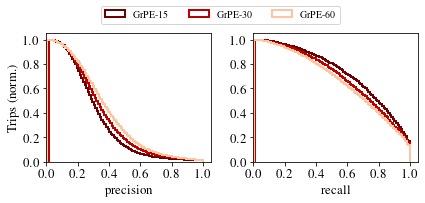

In [289]:
all_methods = ['batch-15-all', 'batch-30-all', 'batch-60-all']

# fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(13,2.4))
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(5.9,2.4))

fig.tight_layout()

plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=13)
plt.rc('ytick', labelsize=13)
plt.rc('axes', labelsize=13)

for method in all_methods:
    ax1.hist(precisions[method].values(), histtype='step', bins=100, linewidth=2, 
             cumulative=-1, color=methodColors[method], 
             label=methodLabels[method], density=True)  # arguments are passed to np.histogram

ax1.set_ylabel('Trips (norm.)')
ax1.set_xlabel('precision')
ax1.set_ylim(0,1.05)
ax1.set_xlim(0,1.05)
ax1.set_xticks([0,0.2,0.4,0.6,0.8,1.0])
ax1.set_yticks([0,0.2,0.4,0.6,0.8,1.0])
    
for method in all_methods:
    ax2.hist(recalls[method].values(), histtype='step', bins=100, linewidth=2,
             cumulative=-1, color=methodColors[method], label=methodLabels[method],
             density=True)  # arguments are passed to np.histogram

#vp2.set_ylabel('Trips (norm.)')
ax2.set_xlabel('recall')
ax2.set_ylim(0,1.05)
ax2.set_xlim(0,1.05)
ax2.set_xticks([0,0.2,0.4,0.6,0.8,1.0])
ax2.set_yticks([0,0.2,0.4,0.6,0.8,1.0])

# for method in all_methods:
#     f1s={}
#     for trip_id, recall, precision in zip(recalls[method], recalls[method].values(), precisions[method].values()):
#         f1s[trip_id] = 2 *((precision * recall)/(precision + recall))
#     ax3.hist(f1s.values(), histtype='step', bins=100, linewidth=2,
#              cumulative=-1, color=methodColors[method], label=methodLabels[method],
#              density=True)  # arguments are passed to np.histogram

# #ax3.set_ylabel('Trips (norm.)')
# ax3.set_xlabel('f1')
# ax3.set_ylim(0,1.05)
# ax3.set_xlim(0,1.05)
# ax3.set_xticks([0,0.2,0.4,0.6,0.8,1.0])
# ax3.set_yticks([0,0.2,0.4,0.6,0.8,1.0])



plt.subplots_adjust(hspace=0.3)

# plt.legend(loc='upper center', bbox_to_anchor=(-0.75, 1.25), ncol=4)
plt.legend(loc='upper center', bbox_to_anchor=(-0.2,1.25), ncol=3)

print('saving pdf')
plt.savefig(os.path.join(output_path, 'BATCH-route-hists.pdf'), bbox_inches='tight')

print('plotting')
plt.show()

### Batch Selection

saving pdf
plotting


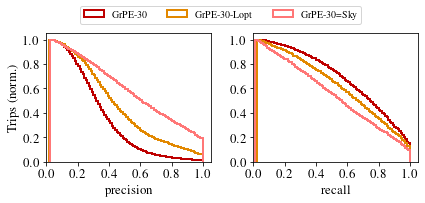

In [288]:
all_methods = ['batch-30-all', 'batch-30-lopt', 'batch-30-skyline']#, 'batch-30-div-10', 'batch-30-div-30', 'batch-30-div-70']

# fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(13,2.4))
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(5.9,2.4))

fig.tight_layout()

plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=13)
plt.rc('ytick', labelsize=13)
plt.rc('axes', labelsize=13)

for method in all_methods:
    ax1.hist(precisions[method].values(), histtype='step', bins=100, linewidth=2, 
             cumulative=-1, color=methodColors[method], 
             label=methodLabels[method], density=True)  # arguments are passed to np.histogram

ax1.set_ylabel('Trips (norm.)')
ax1.set_xlabel('precision')
ax1.set_ylim(0,1.05)
ax1.set_xlim(0,1.05)
ax1.set_xticks([0,0.2,0.4,0.6,0.8,1.0])
ax1.set_yticks([0,0.2,0.4,0.6,0.8,1.0])
    
for method in all_methods:
    ax2.hist(recalls[method].values(), histtype='step', bins=100, linewidth=2,
             cumulative=-1, color=methodColors[method], label=methodLabels[method],
             density=True)  # arguments are passed to np.histogram

#vp2.set_ylabel('Trips (norm.)')
ax2.set_xlabel('recall')
ax2.set_ylim(0,1.05)
ax2.set_xlim(0,1.05)
ax2.set_xticks([0,0.2,0.4,0.6,0.8,1.0])
ax2.set_yticks([0,0.2,0.4,0.6,0.8,1.0])

# for method in all_methods:
#     f1s={}
#     for trip_id, recall, precision in zip(recalls[method], recalls[method].values(), precisions[method].values()):
#         f1s[trip_id] = 2 *((precision * recall)/(precision + recall))
#     ax3.hist(f1s.values(), histtype='step', bins=100, linewidth=2,
#              cumulative=-1, color=methodColors[method], label=methodLabels[method],
#              density=True)  # arguments are passed to np.histogram

# #ax3.set_ylabel('Trips (norm.)')
# ax3.set_xlabel('f1')
# ax3.set_ylim(0,1.05)
# ax3.set_xlim(0,1.05)
# ax3.set_xticks([0,0.2,0.4,0.6,0.8,1.0])
# ax3.set_yticks([0,0.2,0.4,0.6,0.8,1.0])



plt.subplots_adjust(hspace=0.3)

# plt.legend(loc='upper center', bbox_to_anchor=(-0.75, 1.25), ncol=4)
plt.legend(loc='upper center', bbox_to_anchor=(-0.2,1.25), ncol=3)

print('saving pdf')
plt.savefig(os.path.join(output_path, 'BATCH-select-route-hists.pdf'), bbox_inches='tight')

print('plotting')
plt.show() 

saving pdf
plotting


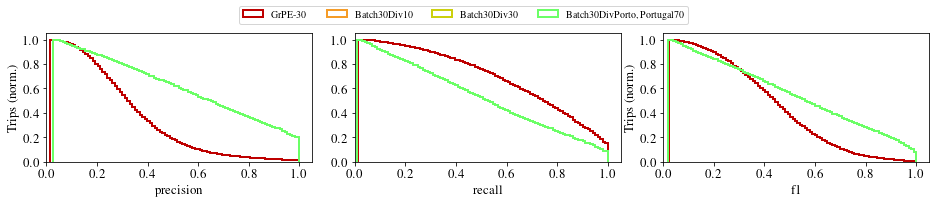

In [209]:
all_methods = ['batch-30-all', 'batch-30-div-10', 'batch-30-div-30', 'batch-30-div-70']

fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(13,2.4))

fig.tight_layout()

plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=13)
plt.rc('ytick', labelsize=13)
plt.rc('axes', labelsize=13)

for method in all_methods:
    ax1.hist(precisions[method].values(), histtype='step', bins=100, linewidth=2, 
             cumulative=-1, color=methodColors[method], 
             label=methodLabels[method], density=True)  # arguments are passed to np.histogram

ax1.set_ylabel('Trips (norm.)')
ax1.set_xlabel('precision')
ax1.set_ylim(0,1.05)
ax1.set_xlim(0,1.05)
ax1.set_xticks([0,0.2,0.4,0.6,0.8,1.0])
ax1.set_yticks([0,0.2,0.4,0.6,0.8,1.0])
    
for method in all_methods:
    ax2.hist(recalls[method].values(), histtype='step', bins=100, linewidth=2,
             cumulative=-1, color=methodColors[method], label=methodLabels[method],
             density=True)  # arguments are passed to np.histogram

#vp2.set_ylabel('Trips (norm.)')
ax2.set_xlabel('recall')
ax2.set_ylim(0,1.05)
ax2.set_xlim(0,1.05)
ax2.set_xticks([0,0.2,0.4,0.6,0.8,1.0])
ax2.set_yticks([0,0.2,0.4,0.6,0.8,1.0])

for method in all_methods:
    f1s={}
    for trip_id, recall, precision in zip(recalls[method], recalls[method].values(), precisions[method].values()):
        f1s[trip_id] = 2 *((precision * recall)/(precision + recall))
    ax3.hist(f1s.values(), histtype='step', bins=100, linewidth=2,
             cumulative=-1, color=methodColors[method], label=methodLabels[method],
             density=True)  # arguments are passed to np.histogram

ax3.set_ylabel('Trips (norm.)')
ax3.set_xlabel('f1')
ax3.set_ylim(0,1.05)
ax3.set_xlim(0,1.05)
ax3.set_xticks([0,0.2,0.4,0.6,0.8,1.0])
ax3.set_yticks([0,0.2,0.4,0.6,0.8,1.0])



plt.subplots_adjust(hspace=0.3)

plt.legend(loc='upper center', bbox_to_anchor=(-0.75, 1.25), ncol=4)

print('saving pdf')
plt.savefig(os.path.join(output_path, 'BATCH-div-route-hists.pdf'), bbox_inches='tight')

print('plotting')
plt.show() 

## Map plots

### Preparation

In [261]:
# Select path
import random


# search_id = '1372664401620000443'# <- kind of ok, but only one result in pen-sky
#search_id = '1372651473620000454' # <- far from fp
#search_id = '1372659744620000269'
#search_id = '1372663588620000161'
search_id = '1372689732620000448'

cpath = None
trip_id = None
with open(ground_truth_file, newline='') as csvfile:
    spamreader = csv.DictReader(csvfile, delimiter=',', quotechar='"')
    for row in spamreader:
        trip_id = row['TRIP_ID']
        if trip_id == search_id:
            cpath = ast.literal_eval(row['CPATH'])
            start_node = int(row['START_NODE'])
            end_node = int(row['END_NODE'])
            break
        


print('trip_id', trip_id)

# Ground truth
head = cpath[0][0]
tail = list(map(lambda x: x[1], cpath))
path = [head] + tail


# create bounding box for path
lon = []
lat = []
for n in G_multi_graph.nodes(data=True):
    if n[0] in path:
        lon.append(n[1]['x'])
        lat.append(n[1]['y'])        
# west = min(lon) - 0.0025
# east = max(lon) + 0.0025
# south = min(lat) - 0.0025
# north = max(lat) + 0.0025
west = min(lon) - 0.025
east = max(lon) + 0.025
south = min(lat) - 0.025
north = max(lat) + 0.025

bbox = (north, south, east, west)


trip_id 1372689732620000448


In [262]:
# prepare svp subgraph and bounding box
result_file = 'datasets/porto/resources/vp/trajectories_2013-07-01.csv/' + trip_id +'.csv'

nodeSet = set()
with open(result_file, newline='') as csvfile:
    spamreader = csv.DictReader(csvfile, delimiter=',', quotechar='"')
    for row in spamreader:
        path = ast.literal_eval(row['NODE_PATH'])
        if not all(p in nodeSet for p in path):
            nodeSet.update(path)

print(len(G_multi_graph.nodes()))
svp_graph = G_multi_graph.subgraph(nodeSet)
print(len(sub_graph.nodes()))

for n in sub_graph.nodes(data=True):
    lon.append(n[1]['x'])
    lat.append(n[1]['y'])        
west_svp = min(lon) - 0.0025
east_svp = max(lon) + 0.0025
south_svp = min(lat) - 0.0025
north_svp = max(lat) + 0.0025
bbox_svp = (north_svp, south_svp, east_svp, west_svp)

78080
9663


### Ground Truth

plotting


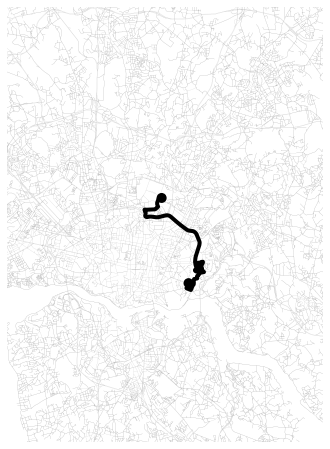

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [276]:
# Ground truth
head = cpath[0][0]
tail = list(map(lambda x: x[1], cpath))
path = [head] + tail


print('plotting')
filepath = os.path.join(output_path, 'map-ground_truth.pdf')
ox.plot_graph_route(G_multi_graph, route=path, route_color='black', route_linewidth=4, route_alpha=1,
                    bgcolor='white', node_size=0, edge_linewidth=.2,
                    bbox=bbox_svp, save=True, filepath=filepath)



### Fastest Path

plotting


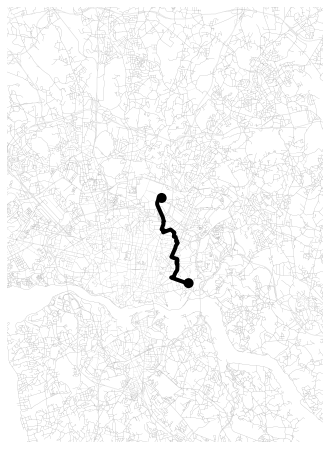

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [277]:
# fastest path
path = nx.shortest_path(G, source=start_node, target=end_node, weight='travel_time')

print('plotting')
filepath = os.path.join(output_path, 'map-fastest.pdf')

ox.plot_graph_route(G_multi_graph, route=path, route_color='black', route_linewidth=4, route_alpha=1,
                    bgcolor='white', node_size=0, edge_linewidth=.2,
                    bbox=bbox_svp, save=True, filepath=filepath)


### Single via Paths

plotting


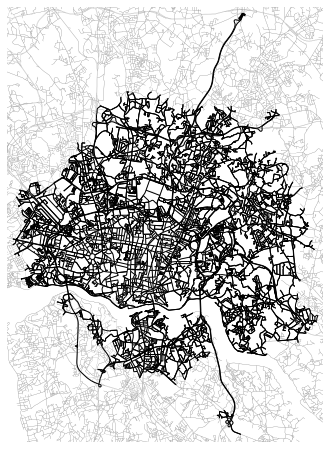

In [280]:





print('plotting')
filepath = os.path.join(output_path, 'map-svp.pdf')

fig, ax = ox.plot.plot_graph(G_multi_graph, bgcolor='white', node_size=0,
                       edge_color='#999999', show=False,
                       edge_linewidth=.2, bbox=bbox_svp)

fig, ax = ox.plot.plot_graph(svp_graph, bgcolor='white', node_size=0,
                       edge_color='black', show=True,
                       edge_linewidth=1, bbox=bbox_svp, ax=ax, save=True, filepath=filepath)


### Penalty

In [106]:
#result_file = 'datasets/porto/resources/pen/trajectories_2013-07-30.csv/' + trip_id +'.csv'
#
#paths = []
#with open(result_file, newline='') as csvfile:
#    spamreader = csv.DictReader(csvfile, delimiter=',', quotechar='"')
#    for row in spamreader:
#        path = ast.literal_eval(row['NODE_PATH'])
#        paths.append(path)
#
#print('plotting')
#filepath = os.path.join(output_path, 'map-pen.pdf')
#ox.plot_graph_routes(G_multi_graph, routes=paths, route_colors='black', route_linewidths=4, route_alpha=1,
#                    bgcolor='white', node_size=0, edge_linewidth=1,
#                    bbox=bbox, save=True, filepath=filepath)
#        
#
#

### Penalty with Skyline

21
3
plotting


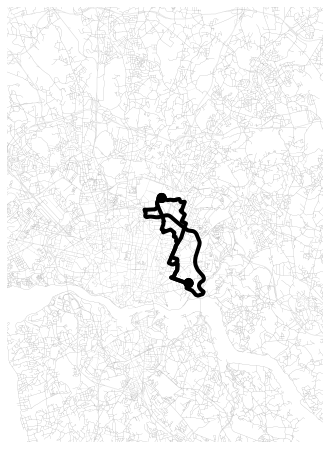

In [279]:
result_file = 'datasets/porto/resources/pen/trajectories_2013-07-01.csv/' + trip_id +'.csv'

paths = []
with open(result_file, newline='') as csvfile:
    spamreader = csv.DictReader(csvfile, delimiter=',', quotechar='"')
    for row in spamreader:
        path = ast.literal_eval(row['NODE_PATH'])
        paths.append(path)

path_list = []
for path in paths:
    distance = nx.path_weight(G, path, 'travel_time')
    highway_types = HighwayExtractor.calculate_highway_types(G, path)
    num_peaks = HighwayExtractor.calculate_highway_peaks(highway_types)
    path_tuple = (path, distance, num_peaks)
    path_list.append(path_tuple)

path_list.sort(key=lambda y: y[1])

min_value = None
res_path = []

first_path = True
replaced = False

for path in path_list:
    if first_path:
        first_path = False
        min_value = path[2]
        res_path.append(path[0])
    elif path[2] < min_value:
        min_value = path[2]
        replaced = True
        res_path.append(path[0])
            
print(len(paths))            
print(len(res_path))

print('plotting')
filepath = os.path.join(output_path, 'map-pen-skyline.pdf')
if len(res_path) == 1:
    ox.plot_graph_route(G_multi_graph, route=res_path[0], route_color='black', route_linewidth=4, route_alpha=1,
                    bgcolor='white', node_size=0, edge_linewidth=.2,
                    bbox=bbox_svp, save=True, filepath=filepath)
else:
    ox.plot_graph_routes(G_multi_graph, routes=res_path, route_colors='black', route_linewidths=4, route_alpha=1,
                    bgcolor='white', node_size=0, edge_linewidth=.2,
                    bbox=bbox_svp, save=True, filepath=filepath)

# ox.plot_graph_route(G_multi_graph, route=res_path[0], route_color='r', route_linewidth=4, route_alpha=0.75,
#                     bgcolor='white', node_size=0, edge_linewidth=2,
#                     bbox=bbox, save=True, filepath=filepath)

In [303]:
def fbeta_score(beta, p, r):
    return (1 + beta) * ((p * r) / ((beta * p) + r))

# todo
# vp-skyline
# -------------
# precision = 0.553
# recall =    0.606
# recall@n =  0.565
# accuracy =  0.466
# -------------

precision = 0.553
recall =    0.606
recallatn =  0.565
accuracy =  0.466

print('vp-skyline')
print('p', precision)
print('r', recall)
print('f0.25', fbeta_score(0.25 , precision, recall))
print('f0.5', fbeta_score(0.5 , precision, recall))
print('f1', fbeta_score(1 , precision, recall))
print('f2', fbeta_score(2 , precision, recall))
print('f4', fbeta_score(4 , precision, recall))
print('r@n', recallatn)
print('acc', accuracy)
print()

# todo
# pen-all
# -------------
precision = 0.180
recall =    0.901
recallatn =  0.857
accuracy =  0.173
# -------------
print('pen-all')
print('p', precision)
print('r', recall)
print('f0.25', fbeta_score(0.25 , precision, recall))
print('f0.5', fbeta_score(0.5 , precision, recall))
print('f1', fbeta_score(1 , precision, recall))
print('f2', fbeta_score(2 , precision, recall))
print('f4', fbeta_score(4 , precision, recall))
print('r@n', recallatn)
print('acc', accuracy)
print()

# todo
# pen-lopt
# -------------
precision = 0.239
recall =    0.815
recallatn =  0.769
accuracy =  0.230
# -------------
print('pen-lopt')
print('p', precision)
print('r', recall)
print('f0.25', fbeta_score(0.25 , precision, recall))
print('f0.5', fbeta_score(0.5 , precision, recall))
print('f1', fbeta_score(1 , precision, recall))
print('f2', fbeta_score(2 , precision, recall))
print('f4', fbeta_score(4 , precision, recall))
print('r@n', recallatn)
print('acc', accuracy)
print()
# todo
# pen-skyline
# -------------
precision = 0.566
recall =    0.595
recallatn =  0.554
accuracy =  0.468
# -------------
print('pen-skyline')
print('p', precision)
print('r', recall)
print('f0.25', fbeta_score(0.25 , precision, recall))
print('f0.5', fbeta_score(0.5 , precision, recall))
print('f1', fbeta_score(1 , precision, recall))
print('f2', fbeta_score(2 , precision, recall))
print('f4', fbeta_score(4 , precision, recall))
print('r@n', recallatn)
print('acc', accuracy)
print()
# todo
# batch-30-all
# -------------
# precision = 0.351
# recall =    0.692
# recall@n =  0.640
# accuracy =  0.330
# -------------

# todo
# batch-30-lopt
# -------------
# precision = 0.465
# recall =    0.631
# recall@n =  0.583
# accuracy =  0.412
# -------------

# todo
# batch-30-skyline
# -------------
# precision = 0.605
# recall =    0.554
# recall@n =  0.510
# accuracy =  0.483
# -------------





vp-skyline
p 0.553
r 0.606
f0.25 0.5628451461202554
f0.5 0.5696056657223796
f1 0.5782881794650561
f2 0.5872394859813084
f4 0.5946025550035486
r@n 0.565
acc 0.466

